In [3]:
# Custom torch Dataset
import os
import numpy as np
import random
import torch
from torch.utils.data import Dataset
from PIL import Image


class EdgeDataset(Dataset):
    def get_negative_pair(self, image_id, label, center):
        """give the center coordinate of positive, scan and get a negative surround"""
        negative = []
        for row in range(center[0]-2, center[0]+3):
            for col in range(center[1]-2, center[1]+3):
                if col < 0 or col > len(label[row]):
                    continue
                if 0 <= row < len(label) and 0 <= col < len(label[row]) and label[row][col] == 0:
                    negative.append((image_id, row, col, 0))
        return negative[random.randint(0, len(negative)-1)]

    def set_attention(self, image_id):
        """get the positive list with its negative pair, ignore the other"""
        label = self.label_list[image_id]
        attention = []    # positive and negative coordinate that is going to be saved.
        for row in range(0, len(label)):
            for col in range(0, len(label[row])):
                if label[row][col] != 0:   # positive coordinate
                    attention.append((image_id, row, col, 1))
                    attention.append(self.get_negative_pair(image_id, label, (row, col)))   # negative pair
        return attention

    def __init__(self, image_path, label_path):
        """Edge detect dataset.
            Add several random pure color block to make pos:neg equals to 1:2. \n
            No extra pure plock is stored, but return pure color when index is in a specific range. \n

        :param image_path: source image path
        :param label_path: label image path
        """
        self.point_list = []

        file_name = os.listdir(image_path)
        self.image_list = []
        self.label_list = []
        for name in file_name:
            image = Image.open(image_path + name)
            label = Image.open(label_path + name)
            self.image_list.append(np.array(image))
            self.label_list.append(np.array(label))

        for img_id in range(0, len(self.image_list)):
            self.point_list.extend(self.set_attention(img_id))

        self.size = len(self.point_list)    # length of meaningful point
        self.length = int(self.size * 1.5)  # length of index access range

    def __len__(self):
        return self.length

    @staticmethod
    def from_center_5x5(arr, center_row, center_col):
        """sample a 5x5 sub array from data by center coordinate"""
        center_5x5 = np.zeros((5, 5))
        for row in range(center_row - 2, center_row + 3):
            for col in range(center_col - 2, center_col + 3):
                if 0 <= row < len(arr) and 0 <= col < len(arr[row]):
                    center_5x5[row - center_row + 2][col - center_col + 2] = arr[row][col]
        return center_5x5

    def __getitem__(self, index):
        if type(index) == int:
            if 0 <= index < self.size:
                point = self.point_list[index]
                image_slice = self.from_center_5x5(self.image_list[point[0]], point[1], point[2])
                image_slice = torch.tensor(image_slice)
                return image_slice, point[3]
            elif self.size <= index < self.length:
                image_slice = torch.full((5, 5), random.randint(0, 255))
                return image_slice, 0
            else:
                raise IndexError("Index out of range!")
        else:
            raise TypeError("Type of index has to be int!")


dataset = EdgeDataset("./source_images(examples)/data/", "./source_images(examples)/edge/")
print("dataset size:", len(dataset))
print(dataset[0])

dataset size: 13680
(tensor([[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  12., 233., 255.],
        [  0.,   0.,  12., 233., 255.],
        [  0.,   0.,   7., 201., 255.]], dtype=torch.float64), 1)


In [4]:
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(25, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 2)

    def forward(self, x):
        x = torch.flatten(x, 1).to(torch.float32)
        x = torch.divide(x, 255.0)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.relu(self.fc3(x))
        x = self.fc4(x)

        return x


train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        img_slice, img_label = data

        optimizer.zero_grad()
        outputs = net(img_slice)
        loss = criterion(outputs, img_label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 1000 == 999:
            print(f"[{epoch + 1}, {i + 1:5d} * 4] loss {running_loss / 1000:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,  1000 * 4] loss 0.643
[1,  2000 * 4] loss 0.604
[1,  3000 * 4] loss 0.269
[2,  1000 * 4] loss 0.073
[2,  2000 * 4] loss 0.054
[2,  3000 * 4] loss 0.055
Finished Training


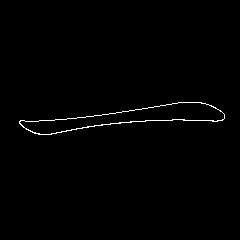

In [5]:
def edge_detect(image_path, file_name):
    image = np.array(Image.open(image_path + file_name).convert('L'))
    height = len(image)
    width = len(image[0])
    edge = np.zeros((height, width))
    for row in range(0, len(image)):
        for col in range(0, len(image[row])):
            input_slice = EdgeDataset.from_center_5x5(image, row, col)
            input_slice = input_slice[np.newaxis, :, :]
            pix_output = net(torch.tensor(input_slice))
            if pix_output[0][0] > pix_output[0][1]:
                edge[row][col] = 0
            else:
                edge[row][col] = 255
    edge = np.uint8(edge)
    return Image.fromarray(edge)

edge_detect("./source_images(examples)/data/", "4-0-0-0-1-0.bmp")

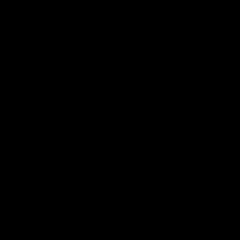

In [6]:
edge_detect("./test_images/synthetic characters/", "0-0-0-0-0.bmp")

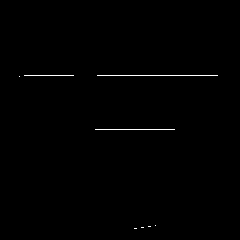

In [7]:
edge_detect("./test_images/synthetic characters/", "0-0-0-0-1.bmp")

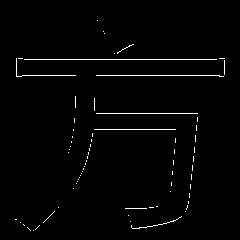

In [8]:
edge_detect("./test_images/synthetic characters/", "0-0-0-0-2.bmp")

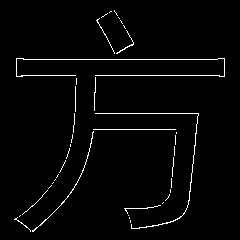

In [9]:
edge_detect("./test_images/synthetic characters/", "0-0-0-0-3.bmp")